In [1]:
import os
import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import re
import nltk
import nltk.stem.porter
import email.message
import operator

#### 1. Загрузите данные ex5data1.mat из файла.

In [2]:
def plotData(X, y):
    pos = np.where(y == 1)
    neg = np.where(y == 0)

    plt.plot(X[pos, 0], X[pos, 1], 'k+', LineWidth=1, MarkerSize=7)
    plt.plot(X[neg, 0], X[neg, 1], 'ko', MarkerFaceColor='y', MarkerSize=7)

In [3]:
data1 = scio.loadmat('data/Lab 5/ex5data1.mat')
X, y = data1['X'], data1['y'][:, 0]

#### 2. Постройте график для загруженного набора данных: по осям - переменные X1, X2, а точки, принадлежащие различным классам должны быть обозначены различными маркерами.

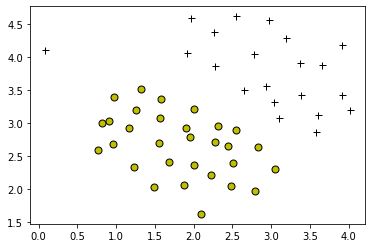

In [4]:
plotData(X, y)
plt.show()

#### 3. Обучите классификатор с помощью библиотечной реализации SVM с линейным ядром на данном наборе.

In [5]:
def visualBoundaryLinear(X, y, theta, b):
    xb = np.linspace(np.min(X[:, 0]), np.max(X[:, 1]), 100)
    yb = -(theta[0] * xb + b) / theta[1]
    plotData(X, y)
    plt.plot(xb, yb, '-b')

In [6]:
model_c1 = svm.SVC(C=1, kernel='linear')
model_c1.fit(X, y)
theta_c1 = model_c1.coef_.flatten()
b_c1 = model_c1.intercept_

model_c100 = svm.SVC(C=100, kernel='linear')
model_c100.fit(X, y)
theta_c100 = model_c100.coef_.flatten()
b_c100 = model_c100.intercept_

#### 4. Постройте разделяющую прямую для классификаторов с различными параметрами C = 1, C = 100 (совместно с графиком из пункта 2). Объясните различия в полученных прямых?

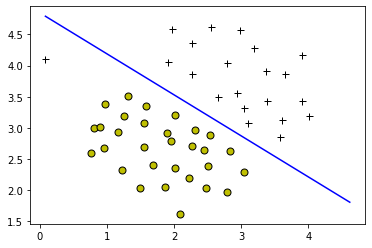

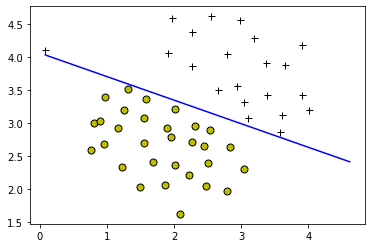

In [7]:
visualBoundaryLinear(X, y, theta_c1, b_c1)
plt.show()

visualBoundaryLinear(X, y, theta_c100, b_c100)
plt.show()

Ответ следует из упрощенной функции потерь, которую необходимо минимизировать:

C ( sum\[ cost(p * | theta |) \] ) + 1/2(sum\[theta ^ 2\]), где:
- p - длины проекций x-ов на theta. Где theta это вектор нормали к разделяющей прямой.
- | theta | - вектор нормали к разделяющей прямой.

Получается, для того чтобы минимизировать эту функцию, нам нужно максимизировать параметр p, или минимизировать параметр theta.
Если мы увеличим параметр C, то, для того, чтобы минимизировать функцию нужны будут большие значение theta, или меньшие значения p.
Вот и получается, что при С=100, расстоние между разделяющей прямой и опорными точками такое маленькое.

#### 5. Реализуйте функцию вычисления Гауссового ядра для алгоритма SVM.

In [8]:
def gaussianKernel(x1, x2, sigma):
    sim = np.exp(-(x1 - x2) @ (x1 - x2) / (2 * sigma ** 2))
    return sim

In [9]:
x1 = np.array([1, 2, 1])
x2 = np.array([0, 4, -1])
sigma = 2
sim = gaussianKernel(x1, x2, sigma)
print('Gaussian Kernel: ', sim)

Gaussian Kernel:  0.32465246735834974


#### 6. Загрузите данные ex5data2.mat из файла.

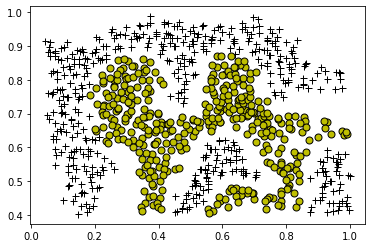

In [10]:
data2 = scio.loadmat('data/Lab 5/ex5data2.mat')
X, y = data2['X'], data2['y'][:, 0]
plotData(X, y)
plt.show()

#### 7. Обработайте данные с помощью функции Гауссового ядра.
#### 8. Обучите классификатор SVM.

In [11]:
sigma = 0.1
model = svm.SVC(C=1, kernel='rbf', gamma=1 / (2 * sigma**2))
model.fit(X, y)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=49.99999999999999,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

#### 9. Визуализируйте данные вместе с разделяющей кривой (аналогично пункту 4).

In [12]:
def visualBoundary(X, y, model):
    x1plot = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
    x2plot = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 100)
    X1, X2 = np.meshgrid(x1plot, x2plot)
    vals = np.zeros(np.shape(X1), dtype=float)
    plotData(X, y)
    for i in range(np.size(X1, 1)):
        this_X = np.vstack((X1[:, i], X2[:, i])).T
        vals[:, i] = model.predict(this_X)
    plt.contour(X1, X2, vals, colors='b')

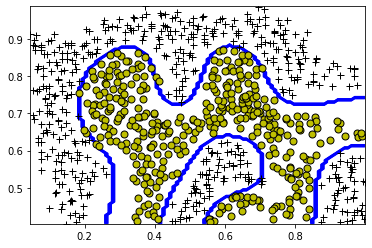

In [13]:
visualBoundary(X, y, model)
plt.show()

#### 10. Загрузите данные ex5data3.mat из файла.

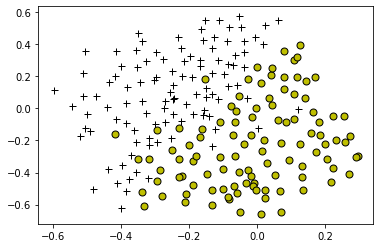

In [14]:
data3 = scio.loadmat('data/Lab 5/ex5data3.mat')
X, y = data3['X'], data3['y'][:, 0]
Xval, yval = data3['Xval'], data3['yval'][:, 0]
plotData(X, y)
plt.show()

#### 11. Вычислите параметры классификатора SVM на обучающей выборке, а также подберите параметры C и σ2 на валидационной выборке.

In [15]:
def dataset3Params(X, y, Xval, yval):
    c = sigma = 0
    lambda_all = np.array([0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]).T
    len_all = np.size(lambda_all, 0)
    errorVal = 999999999

    for i in range(len_all):
        now_c = lambda_all[i]
        for j in range(len_all):
            now_sigma = lambda_all[j]
            model = svm.SVC(C=now_c, kernel='rbf',
                            gamma=1 / (2 * now_sigma**2))
            model.fit(X, y)
            pred = model.predict(Xval)
            error = np.mean(pred != yval)
            if error < errorVal:
                errorVal = error
                c = now_c
                sigma = now_sigma
    return c, sigma

In [16]:
c, sigma = dataset3Params(X, y, Xval, yval)
print('C = ', c, ', sigma = ', sigma)
model = svm.SVC(C=c, kernel='rbf', gamma=1 / (2 * sigma**2))
model.fit(X, y)

C =  1.0 , sigma =  0.1


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=49.99999999999999,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

#### 12. Визуализируйте данные вместе с разделяющей кривой (аналогично пункту 4).

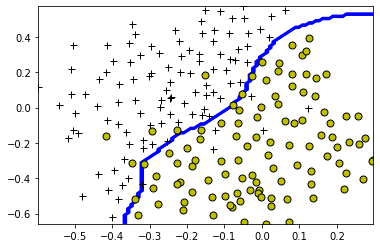

In [17]:
visualBoundary(X, y, model)
plt.show()

#### 13. Загрузите данные spamTrain.mat из файла.

In [18]:
spam_train = scio.loadmat('data/Lab 5/spamTrain.mat')
X, y = spam_train['X'], spam_train['y'][:, 0]

#### 14. Обучите классификатор SVM.

In [19]:
model = svm.SVC(C=0.1, kernel='linear')
model.fit(X, y)
p = model.predict(X)
print('Training Accuracy: ', np.mean(p == y) * 100)

Training Accuracy:  99.825


#### 15. Загрузите данные spamTest.mat из файла.

In [20]:
spam_test = scio.loadmat('data/Lab 5/spamTest.mat')
Xtest, ytest = spam_test['Xtest'], spam_test['ytest'][:, 0]

#### 16. Подберите параметры C и σ2.

In [21]:
c, sigma = dataset3Params(X[:500, :], y[:500], Xtest, ytest)
print('C = ', c, ', sigma = ', sigma)
p = model.predict(Xtest)
print('Test Accuracy: ', np.mean(p == ytest) * 100)

C =  10.0 , sigma =  10.0
Test Accuracy:  98.9


#### 17. Реализуйте функцию предобработки текста письма, включающую в себя: ...
#### 18. Загрузите коды слов из словаря vocab.txt.
#### 19. Реализуйте функцию замены слов в тексте письма после предобработки на их соответствующие коды.

In [22]:
def getVocabList(file='vocab.txt'):
    vocab = {}
    for line in open(f'data/Lab 5/{file}', 'r'):
        (val, key, *others) = line.split()
        vocab[key] = int(val)
    return vocab

In [23]:
def processEmail(email_contents, vocab_file='vocab.txt'):
    vocab = getVocabList(vocab_file)
    word_indices = []
    email_contents = email_contents.lower()
    email_contents = re.sub('<[^<>]+>', ' ', email_contents)
    email_contents = re.sub('[0-9]+', 'number', email_contents)
    email_contents = re.sub('(http|https)://[^\s]*', 'httpaddr', email_contents)
    email_contents = re.sub('[^\s]+@[^\s]+', 'emailaddr', email_contents)
    email_contents = re.sub('[$]+', 'dollar', email_contents)
    email_contents = re.sub('\s+', ' ', email_contents)
    
    # Tokenize Email
    stemmer = nltk.stem.porter.PorterStemmer()
    tokens = re.split('_|number|\W', email_contents)
    
    for token in tokens:
        token = re.sub('[^a-zA-Z0-9]', '', token)
        token = stemmer.stem(token)
        if len(token) < 1:
            continue
        if token in vocab:
            word_indices.append(vocab[token])
            
    return word_indices

In [24]:
def readFile(filename):
    file = open(filename, 'r')
    content = file.read()
    file.close()
    return content

In [25]:
file_contents = readFile('data/Lab 5/emailSample1.txt')
word_indices = processEmail(file_contents)
print('Word Indices:', word_indices)

Word Indices: [86, 916, 794, 1077, 883, 370, 1699, 790, 1822, 1831, 883, 431, 1171, 794, 1002, 1893, 1364, 592, 1676, 238, 162, 89, 688, 945, 1663, 1062, 1699, 375, 1162, 477, 1893, 1510, 799, 1182, 1237, 512, 810, 1895, 1440, 1547, 181, 1699, 1758, 1896, 688, 1676, 992, 961, 1477, 71, 530, 1699, 531]


#### 20. Реализуйте функцию преобразования текста письма в вектор признаков (в таком же формате как в файлах spamTrain.mat и spamTest.mat).

In [26]:
def emailFeatures(word_indices):
    n = 1898
    features = np.zeros((n + 1,), dtype=int)
    for w in word_indices:
        features[w] = 1
    return features

In [27]:
features = emailFeatures(word_indices)
print('Length of feature vector: ', features.size)
print('Number of non-zero entries: ', np.flatnonzero(features).size)

Length of feature vector:  1899
Number of non-zero entries:  45


#### 21. Проверьте работу классификатора на письмах из файлов emailSample1.txt, emailSample2.txt, spamSample1.txt и spamSample2.txt.

In [28]:
def getEmail(path_to_file):
    file_contents = readFile(path_to_file)
    word_indices = processEmail(file_contents)
    return emailFeatures(word_indices)

In [32]:
emailSample1 = getEmail('data/Lab 5/emailSample1.txt')
emailSample2 = getEmail('data/Lab 5/emailSample2.txt')
spamSample1 = getEmail('data/Lab 5/spamSample1.txt')
spamSample2 = getEmail('data/Lab 5/spamSample2.txt')


print('emailSample1 predict: ', model.predict([emailSample1]))
print('emailSample2 predict: ', model.predict([emailSample2]))
print('spamSample1 predict: ', model.predict([spamSample1]))
print('spamSample2 predict: ', model.predict([spamSample2]))

emailSample1 predict:  [0]
emailSample2 predict:  [0]
spamSample1 predict:  [1]
spamSample2 predict:  [1]


#### 22. Также можете проверить его работу на собственных примерах.

In [30]:
grammarlySpamSample = getEmail('data/Lab 5/grammarlySpamSample.txt')
slackShareSpamSample = getEmail('data/Lab 5/slackShareSpamSample.txt')
print('emailSample1 predict: ', model.predict([grammarlySpamSample]))
print('emailSample2 predict: ', model.predict([slackShareSpamSample]))

emailSample1 predict:  [0]
emailSample2 predict:  [0]


К сожалению, мои спам письма модель определила не как спам.
